In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2],
    c2 = [0.5, 2],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = None,
    mask = True))

see one see two 2 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 4
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c2 = np.max([model.optimizer.C2[1] - ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[0]])
    model.optimizer.c1 = np.min([model.optimizer.C1[0] + ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 100, Accuracy: 0.8888888888888888, Loss: 0.3657203956886574
Checkpoint 200, Accuracy: 0.9629629629629629, Loss: 0.11733051582618996
Checkpoint 300, Accuracy: 0.9629629629629629, Loss: 0.10611433453030056
Checkpoint 400, Accuracy: 0.9691358024691358, Loss: 0.10376124028806333
Checkpoint 500, Accuracy: 0.9691358024691358, Loss: 0.10963959164089626


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.9946584  0.00291655 0.00242504]
[0. 1. 0.] <-> [5.4528583e-03 9.9442434e-01 1.2281198e-04]
[1. 0. 0.] <-> [0.9874163  0.01014903 0.00243474]
[1. 0. 0.] <-> [0.991398   0.00181819 0.00678384]
[1. 0. 0.] <-> [0.9948527  0.00318972 0.00195752]
[0. 1. 0.] <-> [0.12115787 0.87764084 0.0012013 ]
[1. 0. 0.] <-> [0.9969253  0.00148685 0.00158782]
[0. 0. 1.] <-> [0.5466531  0.00146322 0.4518837 ]
[1. 0. 0.] <-> [0.9955225  0.00242135 0.00205613]
[0. 0. 1.] <-> [0.54715806 0.00171933 0.4511226 ]
[1. 0. 0.] <-> [0.9958704  0.00160847 0.00252107]
[0. 1. 0.] <-> [1.1006803e-02 9.8877990e-01 2.1332443e-04]
[1. 0. 0.] <-> [0.9643223  0.00242377 0.03325399]
[1. 0. 0.] <-> [0.96432066 0.00223936 0.03343997]
[1. 0. 0.] <-> [0.99226135 0.00137458 0.00636412]
[1. 0. 0.] <-> [0.9946384  0.00212613 0.00323556]
[1. 0. 0.] <-> [0.99631774 0.00167677 0.00200542]
[1. 0. 0.] <-> [0.976315   0.00187246 0.02181259]
[1. 0. 0.] <-> [0.99621093 0.0013775  0.00241155]
[1. 0. 0.] <-> [0.9751027  0.009

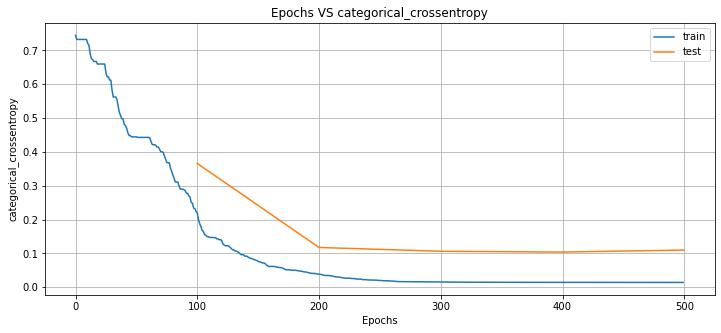

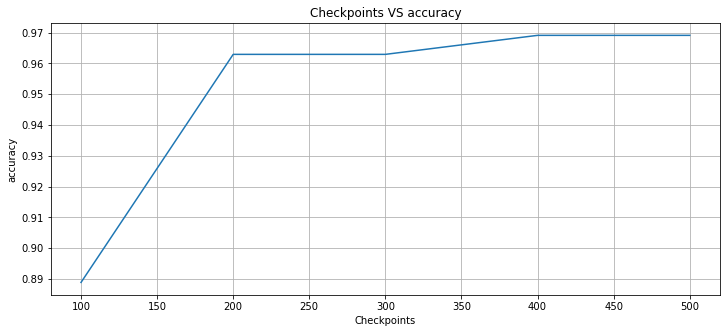

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8888888888888888, 'mean_square_error': 0.21477472217457333, 'categorical_crossentropy': 0.3657203956886574, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 16, 'tn_hit': 14, 'fn_hit': 2}, 1: {'tp_hit': 10, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 6}, 2: {'tp_hit': 4, 'fp_hit': 2, 'tn_hit': 92, 'fn_hit': 10}}, 'checkpoint': 100} 


{'accuracy': 0.9629629629629629, 'mean_square_error': 0.06720967490348123, 'categorical_crossentropy': 0.11733051582618996, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 3, 'tn_hit': 27, 'fn_hit': 3}, 1: {'tp_hit': 15, 'fp_hit': 2, 'tn_hit': 90, 'fn_hit': 1}, 2: {'tp_hit': 12, 'fp_hit': 1, 'tn_hit': 93, 'fn_hit': 2}}, 'checkpoint': 200} 


{'accuracy': 0.9629629629629629, 'mean_square_error': 0.06733482819022324, 'categorical_crossentropy': 0.10611433453030056, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 3, 'tn_hit': 27, 'fn_hit': 3}, 1: {'tp_hit': 15, 'fp_hit': 2, 'tn_hit': 90, 'fn_hit': 1}, 2: {'tp_hit': 12, 'fp_hit': 1, 'tn_hit': 93,

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[ 1.9121263 -3.        -3.         1.9526408  0.6831539]
 bias: 3.0

Neuron 1: weights:
[-0.27128202 -3.          0.41874316  3.          3.        ]
 bias: -1.8294837474822998

Neuron 2: weights:
[-2.0726373  3.         3.        -1.1191903 -1.2596573]
 bias: -3.0

Neuron 3: weights:
[ 0.15321915 -3.         -0.7896322   0.24051327  3.        ]
 bias: -3.0

$
Layer 2
Neuron 0: weights:
[ 3. -3. -3. -3.]
 bias: 0.7956632971763611

Neuron 1: weights:
[-3.        -1.2227081  3.        -3.       ]
 bias: 0.004717638250440359

Neuron 2: weights:
[-0.04856269  3.         -3.          3.        ]
 bias: -3.0

$

